In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import io
import math
import json
import neptune
import tensorflow as tf

import cirq
import numpy as np
from qsgenerator.utils import map_to_radians
from qsgenerator.qugans import circuits
from qsgenerator.resolvers import resolve_all
from qsgenerator.qugans.training import Trainer
from qsgenerator.phase.circuits import build_ground_state_circuit
from qsgenerator.phase.constants import z1_theta, z2_theta
from qsgenerator.phase.analitical import  get_ground_state_for_g
from qsgenerator.states.simple_state_circuits import build_x_rotation_state
from qsgenerator.states.simple_rotation_generators import get_binary_x_rotation_provider, get_arcsin_x_rotation_provider
from qsgenerator.phase.analitical import construct_hamiltonian, get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator

In [ ]:
use_neptune = False

In [ ]:
generator_layers = 5
discriminator_layers = 5
data_bus_size = 5

In [ ]:
real_phase = True
generic_generator = False
all_layers_labeling = False
full_layer_labeling = False
use_gen_label_qubit = False
use_disc_label_qubit = False
zxz = False
fixed_gates = {}
# fixed_gates = {"z1": z1_theta}

In [ ]:
gen, gs, disc, ds, ls, data_qubits, out_qubit = circuits.build_gan_circuits(
    generator_layers, 
    discriminator_layers, 
    data_bus_size, 
    all_layers_labeling=all_layers_labeling,
    full_layer_labeling=full_layer_labeling,
    use_gen_label_qubit=use_gen_label_qubit,
    use_disc_label_qubit=use_disc_label_qubit)

In [ ]:
if not generic_generator:
    gen, gs, symbols_dict_gen = build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)
else:
    symbols_dict_gen = {}

In [ ]:
gen, gs = resolve_all(gen, gs, symbols_dict_gen, fixed_gates)

In [ ]:
if real_phase:
    real, real_symbols, symbols_dict_real = build_ground_state_circuit(qubits=data_qubits)
else:
    real, real_symbols, symbols_dict_real = build_x_rotation_state(qubits=data_qubits)

In [ ]:
pure_gen = gen.copy()
gen.append([disc])

In [ ]:
pure_real = real.copy()
real.append([disc])

In [ ]:
print("REAL GROUND STATE")
pure_real

In [ ]:
print("GENERATOR")
pure_gen

In [ ]:
print("DISCRIMINATOR")
disc

In [ ]:
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([0] * len(gs)) + \
                   np.random.normal(scale=eps, size=(len(gs),))
init_disc_weights = np.random.normal(size=(len(ds),))

gen_weights = tf.Variable(init_gen_weights, dtype=tf.float32)
disc_weights = tf.Variable(init_disc_weights, dtype=tf.float32)

In [ ]:
class CustomScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=4000):
        super(CustomScheduler, self).__init__()
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        return max(math.e ** - ((step+200) / (self.warmup_steps / math.log(100))), 0.01)

In [ ]:
learning_rate = CustomScheduler()

opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
#g_values = [0.1, 0.4, 0.25]
g_values = [-0.5]
# x_rotations = get_binary_x_rotation_provider({0: '100', 1: '011', 2: '101'})
# real_values_provider = get_arcsin_x_rotation_provider(g_values, data_bus_size)
real_values_provider = get_g_parameters_provider()

In [221]:
epochs = 3
disc_iteration = 1
gen_iteration = 1

In [222]:
if use_neptune:
    neptune.init(project_qualified_name='wiktor.jurasz/thesis', api_token=neptun_token)
    neptun_params = {
        'generator_layers': generator_layers,
        'discriminator_layers': discriminator_layers,
        'g_values': g_values,
        'size':  data_bus_size,
        'real_phase': real_phase,
        'generic_generator': generic_generator,
        'all_layers_labeling': all_layers_labeling,
        'full_layer_labeling': full_layer_labeling,
        'use_gen_label_qubit': use_gen_label_qubit,
        'use_disc_label_qubit': use_disc_label_qubit,
        'zxz': zxz,
        'fixed_gates': fixed_gates,
        'disc_iteration': disc_iteration,
        'gen_iteration': gen_iteration,
        'epochs': epochs
    }
    neptune.create_experiment(name=None, description=None, params=neptun_params)
    neptune.log_artifact(io.StringIO(str(disc)), "disc.txt")
    neptune.log_artifact(io.StringIO(str(pure_gen)), "gen.txt")
    neptune.log_artifact(io.StringIO(str(list(init_gen_weights))), 'init_gen_weights.txt')
    neptune.log_artifact(io.StringIO(str(list(init_disc_weights))), 'init_disc_weights.txt')

In [223]:
trainer = Trainer(g_values, 
                  data_bus_size, 
                  disc, 
                  gen, 
                  pure_gen,
                  real, 
                  pure_real,
                  out_qubit, 
                  ds, 
                  gs, 
                  real_symbols, 
                  ls,
                  real_values_provider = real_values_provider,
                  use_analytical_expectation=True,
                  use_neptune=use_neptune)

<Figure size 432x288 with 0 Axes>

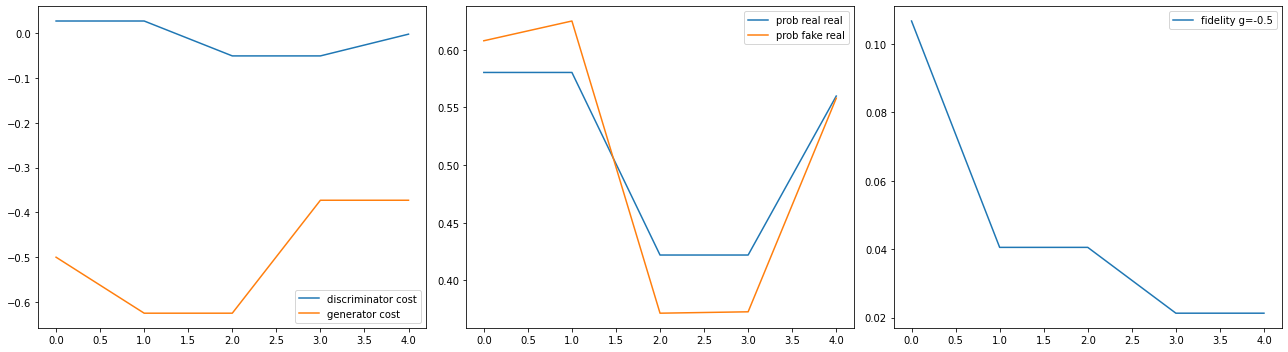

In [ ]:
snapshot_interval_epochs = 20
results, json_result = trainer.train(disc_weights,
      gen_weights, 
      opt, 
      epochs=epochs, 
      disc_iteration=disc_iteration, 
      gen_iteration=gen_iteration,
      snapshot_interval_epochs=snapshot_interval_epochs,
      early_stop_fidelity_threshold=0.2)
res_dict = trainer.get_params_and_results()

In [ ]:
trained_gen_pairs = res_dict['weights'][-1]['gen_pairs']
trained_disc_pairs = res_dict['weights'][-1]['disc_pairs']

In [211]:
trained_gen_pairs = {
      "theta3": "1.3654058",
      "theta2": "1.3495218",
      "theta10": "5.2300096",
      "theta6": "-7.701438",
      "theta4": "-18.066551",
      "theta8": "9.446886",
      "theta0": "-10.680046",
      "theta9": "5.295319",
      "theta12": "-8.847186",
      "theta11": "7.0393486",
      "theta7": "-7.7311254",
      "theta5": "-20.400402",
      "theta1": "18.045677"
    }

In [212]:
gen_evaluator = CircuitEvaluator(pure_gen, ls, trainer.label_value_provider, trained_gen_pairs, gs)
disc_evaluator = CircuitEvaluator(disc, ls, trainer.label_value_provider, trained_disc_pairs, ds)
real_evaluator = CircuitEvaluator(pure_real, real_symbols, trainer.real_values_provider)

In [213]:
if use_neptune:
    neptune.log_artifact(io.StringIO(disc_evaluator.get_resolved_circuit().to_qasm()), 'desc_qasm.txt')
    neptune.log_artifact(io.StringIO(gen_evaluator.get_resolved_circuit().to_qasm()), 'gen_qasm.txt')
    neptune.log_artifact(io.StringIO(json_result), 'weights.json')

In [214]:
def get_gen_for_g(g, gen_weights, gen_provider):
    rad = gen_provider(g)
    return np.append(gen_weights, rad)

def get_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator, 
                                    gen_pairs, 
                                    g, 
                                    sized):
    generated = gen_evaluator.get_state_from_params()
    real = real_evaluator.get_state_from_params(g)
    return generated, real, cirq.fidelity(generated, real)

def get_states_and_fidelty_for_ground(gen_evaluator, g, gen_weights, size):

    generated = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    ground = get_ground_state_for_g(g, size)
    return generated, ground, cirq.fidelity(generated, ground)

def compare_generated_for_g(gen_evaluator, g1, g2, gen_weights, size):
    generated1 = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    generated2 = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    return generated1, generated2, cirq.fidelity(generated1, generated2)

In [215]:
def angle_dist(g, phase_angles_provider, weights):
    angles = phase_angles_provider(g)
    z1_rad = 3 * math.pi / 2
    z2_rad = -3 * math.pi / 2
    z1_deg = math.degrees(z1_rad)
    z2_deg = math.degrees(z2_rad)
    
    xr_rad = angles[0]
    xv_rad = angles[1]
    xw_rad = angles[2]
    xr_deg = math.degrees(xr_rad)
    xv_deg = math.degrees(xv_rad)
    xw_deg = math.degrees(xw_rad)
    
    
    norm_w_deg = [math.degrees(w) for w in weights]
    deg_diff = [norm_w_deg[0], z1_deg, norm_w_deg[0] - z1_deg, weights[0], z1_rad]
    
    print(z1_deg,z2_deg,xr_deg,xv_deg,xw_deg)
    return deg_diff

In [216]:
g = g_values[0]
generated_state, real_state, fidelity = \
    get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_pairs, g, data_bus_size)

In [217]:
generated_state, real_state, fidelity

(array([-0.23003557+0.j, -0.3092451 +0.j, -0.23542109+0.j,  0.17317638+0.j,
         0.11002472+0.j,  0.1479102 -0.j, -0.19671294+0.j,  0.14470255+0.j,
         0.10824019+0.j,  0.14551118-0.j,  0.11077428+0.j, -0.08148585+0.j,
         0.12488808+0.j,  0.16789153-0.j, -0.22328708+0.j,  0.1642506 +0.j,
         0.16689011+0.j,  0.2243564 -0.j,  0.17079735+0.j, -0.12563896+0.j,
        -0.0798226 +0.j, -0.10730839+0.j,  0.14271463+0.j, -0.10498127+0.j,
         0.14919445+0.j,  0.20056748-0.j,  0.15268736+0.j, -0.11231721+0.j,
         0.17214134+0.j,  0.23141581-0.j, -0.30777115+0.j,  0.22639728+0.j],
       dtype=complex64),
 array([ 0.22222227+0.j,  0.31426978+0.j,  0.22222224+0.j, -0.15713488+0.j,
        -0.1111111 +0.j, -0.15713485+0.j,  0.22222221+0.j, -0.15713486+0.j,
        -0.11111113+0.j, -0.15713489+0.j, -0.11111112+0.j,  0.07856744+0.j,
        -0.11111112+0.j, -0.15713486+0.j,  0.22222224+0.j, -0.15713488+0.j,
        -0.15713489+0.j, -0.22222227+0.j, -0.15713489+0.j,  0.

In [218]:
if use_neptune:
    neptune.log_artifact(io.StringIO(str({"generated_state": generated_state.tolist(), "real_state": real_state.tolist()})), f"states_g={g}.txt")

In [219]:
if use_neptune:
    neptune.stop()

In [ ]:
get_g_parameters_provider()(g)

In [ ]:
real025 = real_evaluator.get_state_from_params(0.25)

In [ ]:
real04 = real_evaluator.get_state_from_params(0.4)
real01 = real_evaluator.get_state_from_params(0.1)

In [ ]:
cirq.fidelity(real025, -real025)

In [ ]:
compare_generated_for_g(gen_evaluator, -0.9, -0.8, trained_gen_weights, data_bus_size)

In [ ]:
g = 0
get_states_and_fidelty_for_ground(gen_evaluator, g, trained_gen_weights, data_bus_size)